In [ ]:

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [ ]:

df = pd.read_csv("/content/credit_risk_dataset.csv")
print("✅ Dataset Loaded Successfully!")
print(df.head())

✅ Dataset Loaded Successfully!
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y

In [ ]:

label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [ ]:

def generate_credit_score(row):
    score = 300

    score += min(row['person_income']/1000, 300)

    score += row['person_emp_length'] * 10

    score += row['cb_person_cred_hist_length'] * 20


    if row['loan_status'] == 1:
        score -= 150
    else:
        score += 50


    if row['loan_percent_income'] > 0.3:
        score -= 50
    else:
        score += 20


    if row['cb_person_default_on_file'] == 1:
        score -= 100
    else:
        score += 30


    return max(300, min(900, score))

df['credit_score'] = df.apply(generate_credit_score, axis=1)

In [ ]:


def classify_risk(score):
    if score >= 750:
        return "Low"
    elif score >= 600:
        return "Medium"
    else:
        return "High"

def give_advice(risk):
    if risk == "Low":
        return "✅ Eligible for premium credit offers. Maintain financial discipline."
    elif risk == "Medium":
        return "⚠️ Pay EMIs on time, avoid multiple loans, increase savings."
    else:
        return "❌ Clear debts quickly, improve savings, avoid default."

df['risk_level'] = df['credit_score'].apply(classify_risk)
df['advice'] = df['risk_level'].apply(give_advice)

print(df[['person_income','person_emp_length','cb_person_cred_hist_length','credit_score','risk_level','advice']].head())

   person_income  person_emp_length  cb_person_cred_hist_length  credit_score  \
0          59000              123.0                           3         900.0   
1           9600                5.0                           2         499.6   
2           9600                1.0                           3         300.0   
3          65500                4.0                           2         300.0   
4          54400                8.0                           4         300.0   

  risk_level                                             advice  
0        Low  ✅ Eligible for premium credit offers. Maintain...  
1       High  ❌ Clear debts quickly, improve savings, avoid ...  
2       High  ❌ Clear debts quickly, improve savings, avoid ...  
3       High  ❌ Clear debts quickly, improve savings, avoid ...  
4       High  ❌ Clear debts quickly, improve savings, avoid ...  


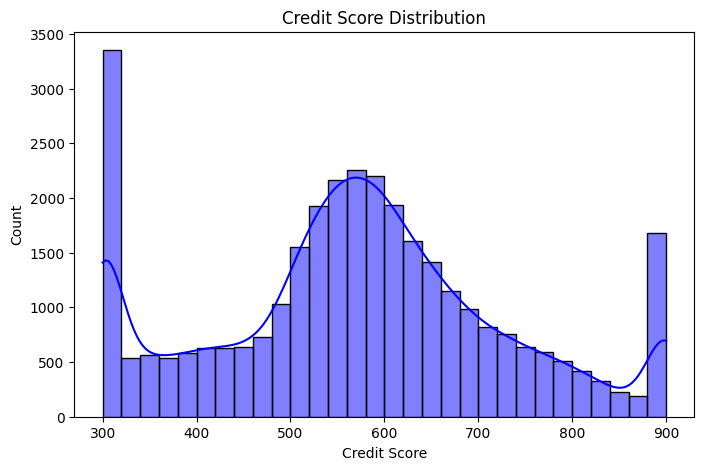

/tmp/ipython-input-1608783761.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="risk_level", data=df, palette="Set2")


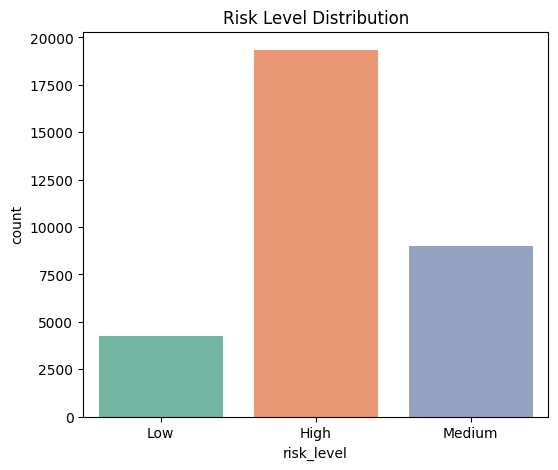

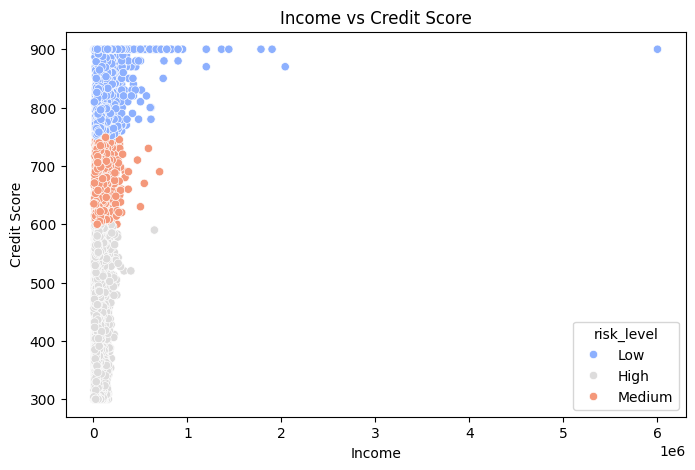

/tmp/ipython-input-1608783761.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="person_emp_length", y="credit_score", data=df, palette="Set3")


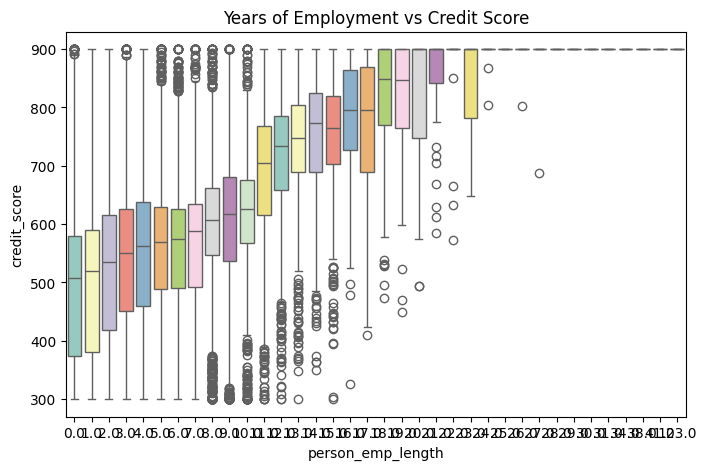

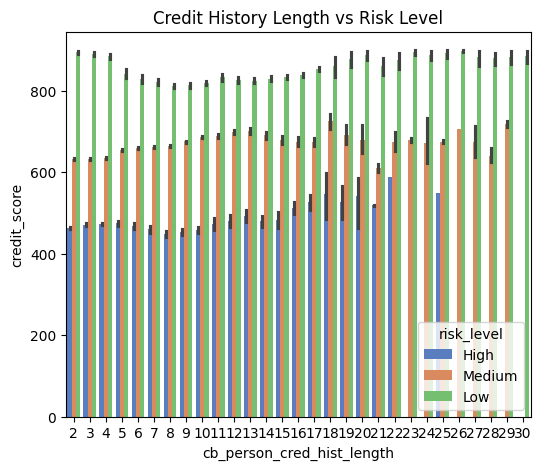

In [ ]:



plt.figure(figsize=(8,5))
sns.histplot(df['credit_score'], bins=30, kde=True, color="blue")
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,5))
sns.countplot(x="risk_level", data=df, palette="Set2")
plt.title("Risk Level Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x="person_income", y="credit_score", hue="risk_level", data=df, palette="coolwarm")
plt.title("Income vs Credit Score")
plt.xlabel("Income")
plt.ylabel("Credit Score")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="person_emp_length", y="credit_score", data=df, palette="Set3")
plt.title("Years of Employment vs Credit Score")
plt.show()

plt.figure(figsize=(6,5))
sns.barplot(x="cb_person_cred_hist_length", y="credit_score", hue="risk_level", data=df, palette="muted")
plt.title("Credit History Length vs Risk Level")
plt.show()

In [ ]:

X = df.drop(columns=['credit_score','risk_level','advice'])
y = df['risk_level']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [8, 10, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=20, scoring='accuracy', cv=cv,
    n_jobs=-1, verbose=1, random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print("✅ Best RF Params:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best RF Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 15}


In [ ]:

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

print("✅ Test Accuracy:", round(acc*100, 2), "%")
print("✅ ROC-AUC:", round(roc, 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


cv_scores = cross_val_score(best_model, X, y, cv=5, scoring="accuracy")
print("✅ Cross-Validation Accuracy:", round(cv_scores.mean()*100, 2), "% ±", round(cv_scores.std()*100, 2))


✅ Test Accuracy: 97.39 %
✅ ROC-AUC: 0.975
Confusion Matrix:
 [[3826    0   43]
 [   0  810   38]
 [  67   22 1711]]
Classification Report:
               precision    recall  f1-score   support

        High       0.98      0.99      0.99      3869
         Low       0.97      0.96      0.96       848
      Medium       0.95      0.95      0.95      1800

    accuracy                           0.97      6517
   macro avg       0.97      0.96      0.97      6517
weighted avg       0.97      0.97      0.97      6517

✅ Cross-Validation Accuracy: 80.85 % ± 12.56


In [ ]:

joblib.dump(best_model, "credit_risk_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
print("✅ Final Model Saved Successfully!")

✅ Final Model Saved Successfully!


In [ ]:

def manual_predict():
    print("\n===== Enter Customer Details =====")
    age = int(input("Enter Age: "))
    income = int(input("Enter Annual Income: "))
    home_ownership = input("Home Ownership (e.g., RENT/OWN/MORTGAGE/OTHER): ")
    employment_length = float(input("Enter Years of Employment: "))
    loan_intent = input("Loan Intent (e.g., EDUCATION/MEDICAL/PERSONAL/VENTURE/HOMEIMPROVEMENT/DEBTCONSOLIDATION): ")
    loan_grade = input("Loan Grade (e.g., A/B/C/D/E/F/G): ")
    loan_amnt = int(input("Enter Loan Amount: "))
    loan_int_rate = float(input("Enter Loan Interest Rate: "))
    loan_status = int(input("Loan Status (0 for no default, 1 for default): "))
    loan_percent_income = float(input("Loan Percent Income (e.g., 0.1 for 10%): "))
    cb_person_default_on_file = input("Previous Default on File (Y/N): ")
    cb_person_cred_hist_length = int(input("Credit History Length (Years): "))



    home_ownership_encoded = label_encoders['person_home_ownership'].transform([home_ownership])[0]
    loan_intent_encoded = label_encoders['loan_intent'].transform([loan_intent])[0]
    loan_grade_encoded = label_encoders['loan_grade'].transform([loan_grade])[0]
    cb_person_default_on_file_encoded = label_encoders['cb_person_default_on_file'].transform([cb_person_default_on_file])[0]


    new_data = pd.DataFrame([{
        'person_age': age,
        'person_income': income,
        'person_home_ownership': home_ownership_encoded,
        'person_emp_length': employment_length,
        'loan_intent': loan_intent_encoded,
        'loan_grade': loan_grade_encoded,
        'loan_amnt': loan_amnt,
        'loan_int_rate': loan_int_rate,
        'loan_status': loan_status,
        'loan_percent_income': loan_percent_income,
        'cb_person_default_on_file': cb_person_default_on_file_encoded,
        'cb_person_cred_hist_length': cb_person_cred_hist_length
    }])



    new_data_scaled = scaler.transform(new_data)


    prediction_encoded = best_model.predict(new_data_scaled)[0]



    score = generate_credit_score({
        'person_income': income,
        'person_emp_length': employment_length,
        'cb_person_cred_hist_length': cb_person_cred_hist_length,
        'loan_status': loan_status,
        'loan_percent_income': loan_percent_income,
        'cb_person_default_on_file': cb_person_default_on_file_encoded # Use encoded value here
    })

    risk_level = classify_risk(score)
    advice = give_advice(risk_level)


    print("\n===== Prediction Result =====")
    print("Credit Score:", score)
    print("Risk Level:", risk_level)
    print("Advice:", advice)


manual_predict()


===== Enter Customer Details =====
Enter Age: 40
Enter Annual Income: 10000
Home Ownership (e.g., RENT/OWN/MORTGAGE/OTHER): RENT
Enter Years of Employment: 13
Loan Intent (e.g., EDUCATION/MEDICAL/PERSONAL/VENTURE/HOMEIMPROVEMENT/DEBTCONSOLIDATION): EDUCATION
Loan Grade (e.g., A/B/C/D/E/F/G): A
Enter Loan Amount: 700000
Enter Loan Interest Rate: 9
Loan Status (0 for no default, 1 for default): 0
Loan Percent Income (e.g., 0.1 for 10%): 0.1
Previous Default on File (Y/N): N
Credit History Length (Years): 5

===== Prediction Result =====
Credit Score: 640.0
Risk Level: Medium
Advice: ⚠️ Pay EMIs on time, avoid multiple loans, increase savings.
